In [4]:
import gym

In [5]:
env = gym.make('MountainCar-v0')

In [6]:
# Observation and action space 
obs_space = env.observation_space
action_space = env.action_space
print("The observation space: {}".format(obs_space))
print("The action space: {}".format(action_space))

The observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space: Discrete(3)


In [7]:
import matplotlib.pyplot as plt 

# reset the environment and see the initial observation
obs = env.reset()
print("The initial observation is {}".format(obs))

# Sample a random action from the entire action space
random_action = env.action_space.sample()

# # Take the action and get the new observation space
new_obs, reward, done, info = env.step(random_action)
print("The new observation is {}".format(new_obs))

The initial observation is [-0.5305456  0.       ]
The new observation is [-0.53149354 -0.0009479 ]


In [7]:
env.render(mode = "human")
env.close()

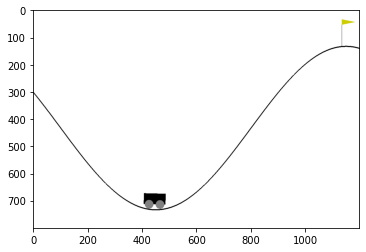

In [8]:
env_screen = env.render(mode = 'rgb_array')
env.close()

import matplotlib.pyplot as plt 
plt.imshow(env_screen)

In [14]:
import time 

# Number of steps you run the agent for 
num_steps = 1500

obs = env.reset()

for step in range(num_steps):
    # take random action, but you can also do something more intelligent
    # action = my_intelligent_agent_fn(obs) 
    action = env.action_space.sample()
    
    # apply the action
    obs, reward, done, info = env.step(action)
    
    # Render the env
    env.render()

    # Wait a bit before the next frame unless you want to see a crazy fast video
    time.sleep(0.001)
    
    # If the epsiode is up, then start another one
    if done:
        env.reset()

# Close the env
env.close()

In [1]:
G = {} # TPG:= {"Teams":, "Edges":}
LE = {} # Learning environment twin: LE
prng_master = []
prng_worker = []
JobQ = []
ResultQ = []
import sys
from __future__ import division
from IPython.display import clear_output
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display
import random

# how to render in Jupyter: 
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# https://www.youtube.com/watch?v=O84KgRt6AJI
def show_state(env, step=0, name='', info=''):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# To transform pixel matrix to a single vector.
def getState(inState):
    # each row is all 1 color
    rgbRows = np.reshape(inState,(len(inState[0])*len(inState), 3)).T

    # add each with appropriate shifting
    # get RRRRRRRR GGGGGGGG BBBBBBBB
    return np.add(np.left_shift(rgbRows[0], 16),
        np.add(np.left_shift(rgbRows[1], 8), rgbRows[2]))

In [2]:
env = gym.make('Assault-v0') # make the environment

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [3]:
print(env.action_space) # learn size of action space

Discrete(7)


In [2]:
# import to do training
from trainer import Trainer1
# from trainer import Trainer
# import to run an agent (always needed)
from agent import Agent1

In [ ]:
# %matplotlib inline
import time # for tracking time

tStart = time.time()

# first create an instance of the TpgTrainer
# this creates the whole population and everything
# teamPopSize should realistically be at-least 100
trainer = Trainer(actions=env.action_space.n, teamPopSize=20) 


# 5 generations isn't much (not even close), but some improvements
# should be seen.
def learning(_trainer, _generation:int):
    # curScores = [] # hold scores in a generation
    summaryScores = [] # record score summaries for each gen (min, max, avg)

    for gen in range(_generation): # generation loop
        curScores = [] # new list per gen
        
        agents = trainer.getAgents()
        
        while True: # loop to go through agents
            teamNum = len(agents)
            agent = agents.pop()
            if agent is None: break # no more agents, so proceed to next gen
            
            state = env.reset() # get initial state and prep environment
            score = 0
            for i in range(500): # run episodes that last 500 frames
                # show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                #         ', Team #' + str(teamNum) +
                #         ', Score: ' + str(score)) # render env
                env.render()
                # get action from agent
                # must transform to at-least int-32 (for my getState to bitshift correctly)
                act = agent.act(getState(np.array(state, dtype=np.int32))) 

                # feedback from env
                state, reward, isDone, debug = env.step(act)
                score += reward # accumulate reward in score

                if isDone: break # end early if losing state

            agent.reward(score) # must reward agent (if didn't already score)
                
            curScores.append(score) # store score
            
            if len(agents) == 0: break
                
        # at end of generation, make summary of scores
        summaryScores.append((min(curScores), max(curScores),
                        sum(curScores)/len(curScores))) # min, max, avg
        trainer.evolve()

    return summaryScores

#clear_output(wait=True)
# print('Time Taken (Hours): ' + str((time.time() - tStart)/3600))
# print('Results:\nMin, Max, Avg')
# for result in summaryScores:
#     print(result[0],result[1],result[2])

In [2]:
def evaluate_all_policies(Num_PE:int):
    # Preper jobs
    idx = 0
    for root in G.Teams:
        seed = prng_master.getNumber()
        job = {idx, seed, root}
        JobQ.append(job)
        idx += 1
    
    # Start parallel threads
    for i in range(1,Num_PE):
        # Spawn thread: Worker(G, JobQ, ResultQ)
        print(i)
    
    # Call Worker(G, JobQ, ResultQ)
    # Join all threads
    # Post-Propocess Results and Trace
    # Sort ResultQ in result.jobId order
    for result in ResultQ:
        # Post-process result.trace // Archiving [10]
        print(result)

def worker():
    # Poll for job
    while JobQ.getNextJob():
        # setup for policy evaluation
        job = JobQ.getNextJob()
        root = job.root
        prng_master.reset(job.seed)
        LE.reset(prng_master.getNumber())
        # Evaluate policy fitness
        trace = evaluate_all_policies(G, root, LE, prng_master)
        result = {}
        result.jobId = job.id
        result.trace = trace
        ResultQ.append(result)

def execute_program(_p, _data):
    for line in _p:
        instruction = line.instruction
        operands = {}
        nbOperands = instruction.operandTypes.size()
        for i in range(nbOperands):
            _type = instruction.dataTypes[i]
            _address = line.operandAdress[i]
            if _data.canProvide(_type, _address):
                operand = _data.getData(_type, _address)
                operands.insert(operand)
            else :
                sys.exit()
            
            result = instruction.execute(operands)
            _data.set(line.register, result)

In [2]:
import numpy as np

In [3]:
a = np.array([1,2,3,4,5])
a

array([1, 2, 3, 4, 5])

In [4]:
print(a)

[1 2 3 4 5]
